https://www.kaggle.com/code/shailaja4247/customer-lifetime-value-prediction/notebook

In [1]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

#레티나 디스플레이로 폰트가 선명하게 표시되도록 합니다.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [1]:
from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
tx_data = pd.read_csv('/content/drive/MyDrive/data/customer_segmentation.csv', encoding='cp1252')

In [3]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Feature Engineering 

In [4]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [5]:
tx_data['InvoiceYearMonth'] = tx_data['InvoiceDate'].apply(lambda x : 100*x.year + x.month)

In [6]:
tx_data.describe()

,Quantity,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909.000000,406829.000000,541909.000000
mean,9.552250,4.611114,15287.690570,201099.713989
std,218.081158,96.759853,1713.600303,25.788703
min,-80995.000000,-11062.060000,12346.000000,201012.000000
25%,1.000000,1.250000,13953.000000,201103.000000
50%,3.000000,2.080000,15152.000000,201107.000000
75%,10.000000,4.130000,16791.000000,201110.000000
max,80995.000000,38970.000000,18287.000000,201112.000000


In [7]:
tx_data['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

Starting from this part, we will be focusing on UK data only (which has the most records). We can get the monthly active customers by counting unique CustomerIDs. The same analysis can be carried out for customers of other countries as well.

In [8]:
#we will be using only UK data
tx_uk = tx_data.query("Country == 'United Kingdom'").reset_index(drop=True)

## Recency 

In [9]:
#create a generic user dataframe to keep CustomerID and new segmentation scores 
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [10]:
#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_uk.groupby('CustomerID')['InvoiceDate'].max().reset_index()
tx_max_purchase.columns = ['CustomerID', 'MaxPurchaseData']
tx_max_purchase.head()

,CustomerID,MaxPurchaseData
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [11]:
# Compare the last transaction of dataset with last transaction dates of the individual customer IDs.
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseData'].max() - tx_max_purchase['MaxPurchaseData']).dt.days 
tx_max_purchase.head()

,CustomerID,MaxPurchaseData,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [12]:
# merge this dataframe to our new user dataframe 
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID', 'Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


### Assigning a recency score 

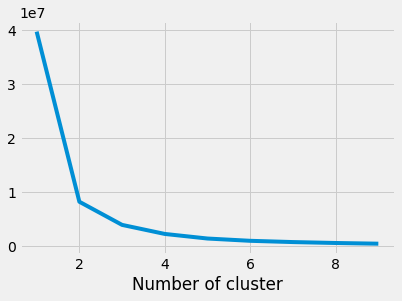

In [13]:
from sklearn.cluster import KMeans 

sse = {} # error 

tx_recency = tx_user[['Recency']]

for k in range(1, 10): 
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
  tx_recency['clusters'] = kmeans.labels_ 
  sse[k] = kmeans.inertia_ # 군집의 응집도 값이 작을수록 군집화가 잘 되었다고 평가 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [14]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
tx_user['RecencyCluster'] = kmeans.fit_predict(tx_user[['Recency']])

In [15]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,0
2,13748.0,95,3
3,15100.0,329,1
4,15291.0,25,0


In [16]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
2,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
3,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0


### Ordering clusters 

In [17]:
# function for ordering cluster numbers 

def order_cluster(cluster_field_name, target_field_name, df, ascending): 
  new_cluster_field_name = 'new_' + cluster_field_name
  df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
  df_new['index'] = df_new.index 
  df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
  df_final = df_final.drop(cluster_field_name, axis=1)
  df_final = df_final.rename(columns={'index' : cluster_field_name})
  return df_final 

In [18]:
tx_user = order_cluster('RecencyCluster', 'Recency', tx_user, False)
tx_user

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0
...,...,...,...
3945,15942.0,133,1
3946,14143.0,133,1
3947,16147.0,133,1
3948,15149.0,133,1


In [19]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


## Frequency 

In [20]:
#get order counts for each user and create a dataframe with it 
tx_frequency = tx_uk.groupby('CustomerID')['InvoiceDate'].count().reset_index()
tx_frequency.columns = ['CustomerID', 'Frequency']
tx_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [21]:
# add this data to our main dataframe 
tx_user = tx_user.merge(tx_frequency, on ='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


### Frequency clusters 

Determine the right number of clusters for K-Means by elbow method 

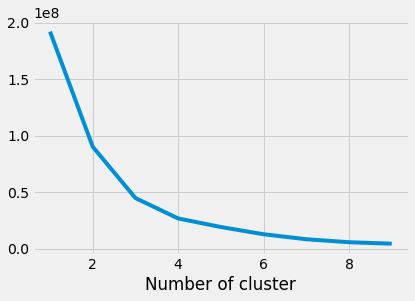

In [22]:
from sklearn.cluster import KMeans 

sse = {} 

tx_frequency = tx_user[['Frequency']]

for k in range(1, 10): 
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)  
  tx_frequency['clusters'] = kmeans.labels_ 
  sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

By Elbow method, clusters number should be 4 as after 4, the graph goes down.

In [23]:
# Applying K-Means 
Kmeans = KMeans(n_clusters=4)
tx_user['FrequencyCluster'] = kmeans.fit_predict(tx_user[['Frequency']])

In [24]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2399.0,23.549812,15.869986,1.0,10.0,21.0,35.0,59.0
1,2.0,4885.000000,343.653896,4642.0,4763.5,4885.0,5006.5,5128.0
2,181.0,344.629834,55.844437,270.0,297.0,329.0,392.0,463.0
3,5.0,2089.400000,516.483591,1640.0,1677.0,1857.0,2491.0,2782.0
4,1.0,7983.000000,NaN,7983.0,7983.0,7983.0,7983.0,7983.0
5,67.0,585.761194,91.042130,468.0,504.0,563.0,665.0,803.0
6,369.0,193.135501,34.891650,145.0,163.0,188.0,219.0,269.0
7,909.0,94.443344,23.983069,60.0,73.0,91.0,113.0,144.0
8,17.0,1084.823529,159.934063,872.0,977.0,1076.0,1160.0,1508.0


In [25]:
# order the frequency cluster 
tx_user = order_cluster('FrequencyCluster', 'Frequency', tx_user, True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2399.0,23.549812,15.869986,1.0,10.0,21.0,35.0,59.0
1,909.0,94.443344,23.983069,60.0,73.0,91.0,113.0,144.0
2,369.0,193.135501,34.891650,145.0,163.0,188.0,219.0,269.0
3,181.0,344.629834,55.844437,270.0,297.0,329.0,392.0,463.0
4,67.0,585.761194,91.042130,468.0,504.0,563.0,665.0,803.0
5,17.0,1084.823529,159.934063,872.0,977.0,1076.0,1160.0,1508.0
6,5.0,2089.400000,516.483591,1640.0,1677.0,1857.0,2491.0,2782.0
7,2.0,4885.000000,343.653896,4642.0,4763.5,4885.0,5006.5,5128.0
8,1.0,7983.000000,NaN,7983.0,7983.0,7983.0,7983.0,7983.0


## Revenue 

In [26]:
# calculate revenue for each customer 
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [27]:
# merge it with our main dataframe 
tx_user = tx_user.merge(tx_revenue, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,3,5288.63
1,14688.0,7,3,359,3,5107.38
2,16029.0,38,3,274,3,50992.61
3,13767.0,1,3,399,3,16945.71
4,15513.0,30,3,314,3,14520.08


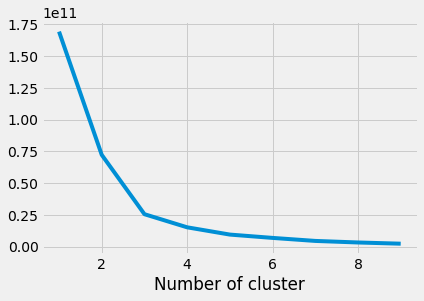

In [28]:
from sklearn.cluster import KMeans

sse={} # error

tx_monetary = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_monetary)
    tx_monetary["clusters"] = kmeans.labels_ 
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

### Revenue clusters 

In [29]:
#apply clustering
kmeans = KMeans(n_clusters=4)
tx_user['RevenueCluster'] = kmeans.fit_predict(tx_user[['Revenue']])

#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue', tx_user, True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


## Overall Score based on RFM Clustering 

In [30]:
# calculate overall score and use mean() to see details 

tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency', 'Frequency', 'Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.554545,16.736364,274.571659
1,193.902778,24.160714,381.332044
2,90.514628,32.034574,668.233235
3,34.285990,43.710145,828.620204
4,23.754934,103.190789,1589.534803
5,17.870748,185.908163,3161.098027
6,14.095588,292.205882,4655.580882
7,10.920354,401.946903,7614.822920
8,7.717949,582.076923,14393.304615


Score 8 is our best customer, score 0 is our worst customer.



In [31]:
tx_user['Segment'] = 'Low-Value'

In [32]:
tx_user.loc[tx_user['OverallScore']>2, 'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']>4, 'Segment'] = 'High-Value'

## Customer Lifetime Value

In [33]:
tx_uk['InvoiceDate'].describe()

count                  495478
unique                  21220
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:49:00
Name: InvoiceDate, dtype: object

We see that customers are active from 1 December 2010. Let us consider customers from March onwards (so that they are not new customers). We shall divide them into 2 subgroups. One will be where timeframe of analysing is 3 months, another will be timeframe of 6 months.

In [34]:
tx_uk.InvoiceDate = pd.to_datetime(tx_uk.InvoiceDate).dt.date
tx_3m = tx_uk[(tx_uk.InvoiceDate < date(2011, 6, 1)) & (tx_uk.InvoiceDate >= date(2011, 3, 1))].reset_index()
tx_3m.InvoiceDate # 3 months time 

0        2011-03-01
1        2011-03-01
2        2011-03-01
3        2011-03-01
4        2011-03-01
            ...    
95188    2011-05-31
95189    2011-05-31
95190    2011-05-31
95191    2011-05-31
95192    2011-05-31
Name: InvoiceDate, Length: 95193, dtype: object

In [35]:
tx_uk.InvoiceDate = pd.to_datetime(tx_uk.InvoiceDate).dt.date
tx_6m = tx_uk[(tx_uk.InvoiceDate >= date(2011, 6, 1)) & (tx_uk.InvoiceDate < date(2011, 12, 1))].reset_index()
tx_6m.InvoiceDate # 6 months time 

0         2011-06-01
1         2011-06-01
2         2011-06-01
3         2011-06-01
4         2011-06-01
             ...    
278961    2011-11-30
278962    2011-11-30
278963    2011-11-30
278964    2011-11-30
278965    2011-11-30
Name: InvoiceDate, Length: 278966, dtype: object

In [36]:
# calculte revenue and create a new dataframe for it 
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID', 'm6_Revenue']

In [37]:
tx_user_6m

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98
...,...,...
3162,18278.0,173.90
3163,18281.0,80.82
3164,18282.0,98.76
3165,18283.0,1351.83


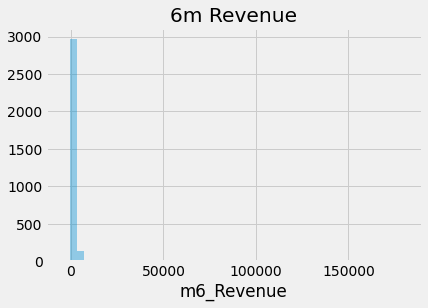

In [38]:
# plot LTV histogram 
sns.distplot(tx_user_6m['m6_Revenue'], kde=False)
plt.title('6m Revenue');

Histogram clearly shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

In [39]:
tx_merge = tx_user.merge(tx_user_6m, on='CustomerID', how='left')
tx_merge = tx_merge.fillna(0)  #Only people who are in the timeline of tx_user_6m
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,17850.0,301,0,312,3,5288.63,1,4,Mid-Value,0.00
1,14688.0,7,3,359,3,5107.38,1,7,High-Value,1702.06
2,13767.0,1,3,399,3,16945.71,1,7,High-Value,8910.04
3,15513.0,30,3,314,3,14520.08,1,7,High-Value,8603.26
4,14849.0,21,3,392,3,7904.28,1,7,High-Value,5498.07


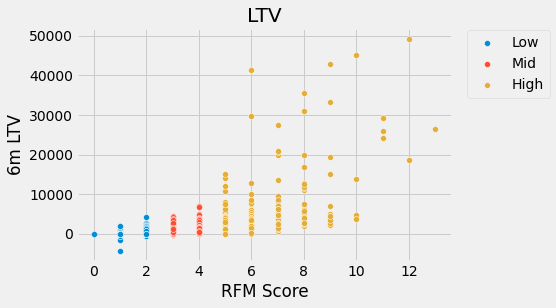

In [40]:
tx_graph = tx_merge.query('m6_Revenue < 50000') #because max values are ending at 50,000 as seen in graph above

sns.scatterplot(data=tx_graph.query('Segment == "Low-Value"'), x='OverallScore', y='m6_Revenue', label='Low')
sns.scatterplot(data=tx_graph.query('Segment == "Mid-Value"'), x='OverallScore', y='m6_Revenue', label='Mid')
sns.scatterplot(data=tx_graph.query('Segment == "High-Value"'), x='OverallScore', y='m6_Revenue', label='High')

plt.title('LTV')
plt.xlabel('RFM Score')
plt.ylabel('6m LTV')
plt.legend(bbox_to_anchor=(1.02, 1.02));

We can visualise correlation between overall RFM score and revenue. Positive correlation is quite visible here. High RFM score means high LTV.

Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):

* Low LTV
* Mid LTV
* High LTV
We are going to apply K-means clustering to decide segments and observe their characteristics

In [41]:
# remove outliers 
tx_merge = tx_merge[tx_merge['m6_Revenue'] < tx_merge['m6_Revenue'].quantile(0.99)]

In [42]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,17850.0,301,0,312,3,5288.63,1,4,Mid-Value,0.00
1,14688.0,7,3,359,3,5107.38,1,7,High-Value,1702.06
4,14849.0,21,3,392,3,7904.28,1,7,High-Value,5498.07
5,13468.0,1,3,306,3,5656.75,1,7,High-Value,1813.09
6,15601.0,10,3,414,3,6745.36,1,7,High-Value,2003.97


In [43]:
# creating 3 clusters 
kmeans = KMeans(n_clusters=3) 
tx_merge['LTVCluster'] = kmeans.fit_predict(tx_merge[['m6_Revenue']])
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,3,5288.63,1,4,Mid-Value,0.00,0
1,14688.0,7,3,359,3,5107.38,1,7,High-Value,1702.06,1
4,14849.0,21,3,392,3,7904.28,1,7,High-Value,5498.07,2
5,13468.0,1,3,306,3,5656.75,1,7,High-Value,1813.09,1
6,15601.0,10,3,414,3,6745.36,1,7,High-Value,2003.97,1


In [44]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue', tx_merge, True)

# creating a new cluster dataframe 
tx_cluster = tx_merge.copy()

In [45]:
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,2981.0,282.036328,286.627690,-4287.63,0.0000,231.60,461.4900,958.46
1,777.0,1635.282355,555.078601,961.56,1168.7600,1509.58,1977.9500,3147.77
2,152.0,4685.321382,1340.544718,3166.40,3563.4725,4278.37,5531.1075,8432.68


There are few more step before training the machine learning model:

* Feature engineering.
* Convert categorical columns to numerical columns.
* We will check the correlation of features against our label, LTV clusters.
* We will split our feature set and label (LTV) as X and y. We use X to predict y.
* Will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our model to Test set to see its real performance.

In [46]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,3,5288.63,1,4,Mid-Value,0.0,0
1,15032.0,255,0,55,0,4464.10,1,1,Low-Value,0.0,0
2,16000.0,2,3,9,0,12393.70,1,4,Mid-Value,0.0,0
3,15749.0,234,1,15,0,21535.90,1,2,Low-Value,0.0,0
4,13093.0,266,0,170,2,7741.47,1,3,Mid-Value,0.0,0


### Feature engineering 

In [47]:
# convert categorical columns to numerical 
tx_class = pd.get_dummies(tx_cluster)
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,3,5288.63,1,4,0.0,0,0,0,1
1,15032.0,255,0,55,0,4464.10,1,1,0.0,0,0,1,0
2,16000.0,2,3,9,0,12393.70,1,4,0.0,0,0,0,1
3,15749.0,234,1,15,0,21535.90,1,2,0.0,0,0,1,0
4,13093.0,266,0,170,2,7741.47,1,3,0.0,0,0,0,1


In [48]:
# calculate and show correlations 
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.878888
Revenue               0.776532
OverallScore          0.633204
FrequencyCluster      0.630540
RevenueCluster        0.607540
Segment_High-Value    0.603418
Frequency             0.567484
RecencyCluster        0.355218
Segment_Mid-Value    -0.026781
CustomerID           -0.027210
Recency              -0.346594
Segment_Low-Value    -0.403302
Name: LTVCluster, dtype: float64

In [49]:
# create X and y, X will be feature set and y is the label - LTV 
X = tx_class.drop(['LTVCluster', 'm6_Revenue'], axis=1)
y = tx_class['LTVCluster'] 

# split training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

We see that Revenue, Frequency and RFM scores will be helpful for our machine learning models from the correlation with LTVCluster.

## Machine Learning Model for Customer Lifetime Value Prediction 

Since our LTV Clusters are 3 types, high LTV, mid LTV and low LTV; we will perform multi class classification.

In [50]:
#XGBoost Multiclassification Model 
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_jobs=-1)
ltv_xgb_model.fit(X_train, y_train) 

print('Accuracy of XGB classfier on training set: {:.2f}'.format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classfier on test set: {:.2f}'.format(ltv_xgb_model.score(X_test, y_test)))

y_pred = ltv_xgb_model.predict(X_test)

Accuracy of XGB classfier on training set: 0.96
Accuracy of XGB classfier on test set: 0.90


Accuracy looks good on training and test set. Let's check the precision, recall, fscore too

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       146
           1       0.82      0.74      0.78        43
           2       0.57      0.57      0.57         7

    accuracy                           0.90       196
   macro avg       0.78      0.76      0.77       196
weighted avg       0.90      0.90      0.90       196



## Final Clusters for Customer Lifetime Value 

* Cluster 0: Good precision, recall, f1-score and support
* Cluster 1: Needs better precision, recall and f1-score
* Cluster 2: Bad precision, F1-Score needs improvement

In [52]:
y_test

1212    0
1584    0
954     0
3723    1
336     0
       ..
1994    0
2198    0
45      0
3681    1
3172    1
Name: LTVCluster, Length: 196, dtype: int64

In [53]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 2, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])